In [14]:
from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import *
from tensorflow.keras.layers import Activation, Dropout, Dense,Conv2D,ConvLSTM2D,MaxPooling2D
from tensorflow.keras.layers import Flatten, LSTM, Concatenate, TimeDistributed
from tensorflow.keras.layers import GlobalMaxPooling1D, MaxPooling3D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional

import pandas as pd
import numpy as np
import seaborn as sns
import pydicom
import os
import re

import matplotlib.pyplot as plt

In [2]:
#For error = TensorFlow: Blas GEMM launch failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print('physical_devices : ', physical_devices)

physical_devices :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_csv("D:\\Data\\OSIC\\osic-pulmonary-fibrosis-progression\\train.csv")

In [4]:
#Exploratory Data Analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [5]:
df.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [6]:
print("Q. How many patients are present in train set ?")
print("A.",df['Patient'].nunique())
print("------------")
print("Q. How many unique ages are present in train set ?")
print("A.",df['Age'].nunique())
print("------------")
print("Q. How many smoking statuses are present in train set ?")
print("A.",df['SmokingStatus'].nunique())

Q. How many patients are present in train set ?
A. 176
------------
Q. How many unique ages are present in train set ?
A. 34
------------
Q. How many smoking statuses are present in train set ?
A. 3


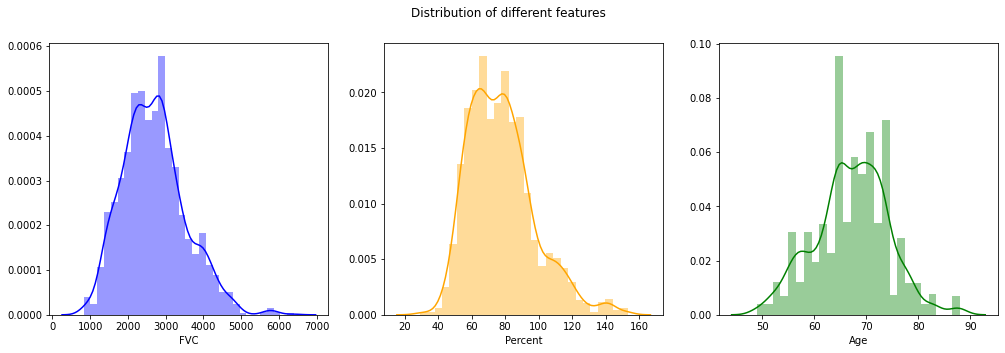

In [7]:
#How 'FVC', 'Percent' and 'Age' are distributed
fig, axes = plt.subplots(1, 3, figsize=(17,5))
fig.suptitle('Distribution of different features')

sns.distplot(df['FVC'], color='blue', ax=axes[0])
sns.distplot(df['Percent'], color='orange', ax=axes[1])
sns.distplot(df['Age'],color='green', ax=axes[2])

plt.show()

No of Patient :  (176,)
Max record of patient :  10
Min record of patient :  6


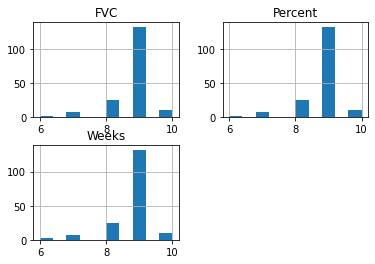

In [8]:
print ("No of Patient : " , df.Patient.unique().shape)

df_gb = df.groupby(['Patient','Age','Sex','SmokingStatus']).count()

print("Max record of patient : " , df_gb["Weeks"].max())

print("Min record of patient : " , df_gb["Weeks"].min())

df_gb.hist()

plt.show()

Age distribution
Sex distribution
Male      139
Female     37
Name: Sex, dtype: int64
SmokingStatus distribution
Ex-smoker           118
Never smoked         49
Currently smokes      9
Name: SmokingStatus, dtype: int64
Relation between Age and Sex


<ipython-input-9-36636e86c18f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Sex'] = flg
<ipython-input-9-36636e86c18f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['Sex']=b['Sex'].astype(int)


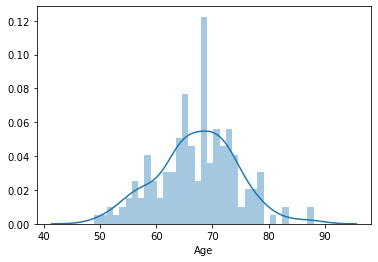

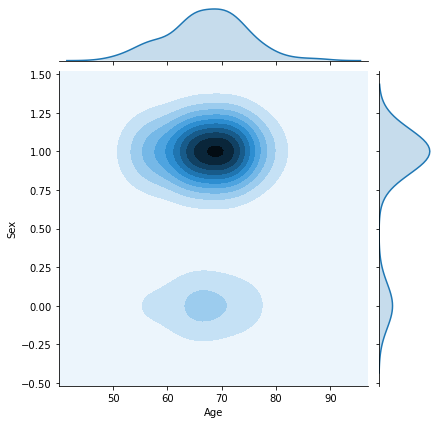

In [9]:
df_gb2 = df_gb.reset_index()

print('Age distribution')
sns.distplot(df_gb2['Age'],bins=35)

print('Sex distribution')
print(df_gb2['Sex'].value_counts())

print('SmokingStatus distribution')
print(df_gb2['SmokingStatus'].value_counts())

b = df_gb2[['Age','Sex']]
flg = b['Sex']=='Male'
b['Sex'] = flg
b['Sex']=b['Sex'].astype(int)

print("Relation between Age and Sex")
sns.jointplot(x="Age", y="Sex", data=b, kind="kde")
plt.show()


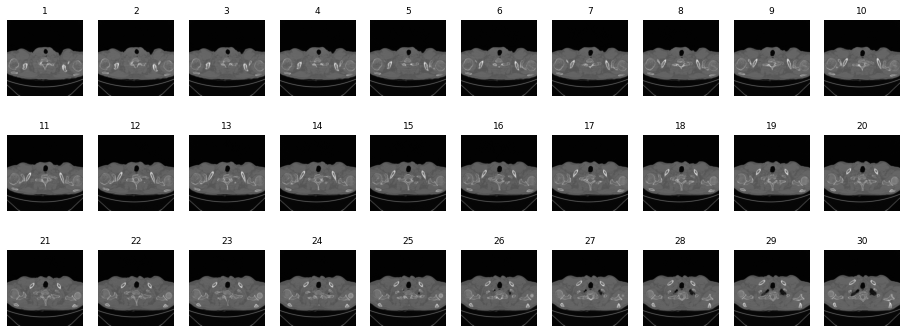

In [10]:
patient_dir = "D:\\Data\\OSIC\\osic-pulmonary-fibrosis-progression\\train\\ID00038637202182690843176"

datasets = []

# First Order the files in the dataset
files = []
for dcm in list(os.listdir(patient_dir)):
    files.append(dcm) 
files.sort(key=lambda f: int(re.sub('\D', '', f)))

# Read in the Dataset
for dcm in files:
    path = patient_dir + "/" + dcm
    datasets.append(pydicom.dcmread(path))

# Plot the images
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = datasets[i-1].pixel_array
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.title(i, fontsize = 9)
    plt.axis('off');

plt.show()


-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00007637202177411956430
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00007637202177411956430
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00007637202177411956430
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00007637202177411956430
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00007637202177411956430
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00007637202177411956430
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00007637202177411956430
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00007637202177411956430
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00007637202177411956430
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00009637202177434476278
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID000096372021

<ipython-input-11-763b07ad634f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["CT_number"][k] = len(os.listdir(path))


-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00129637202219868188000
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00129637202219868188000
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00130637202220059448013
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00130637202220059448013
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00130637202220059448013
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00130637202220059448013
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00130637202220059448013
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00130637202220059448013
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00130637202220059448013
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00130637202220059448013
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID001306372022

-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00276637202271694539978
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00276637202271694539978
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00276637202271694539978
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00276637202271694539978
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00276637202271694539978
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00279637202272164826258
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00279637202272164826258
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00279637202272164826258
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00279637202272164826258
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID00279637202272164826258
-------->  D:\Data\OSIC\osic-pulmonary-fibrosis-progression\train/ID002796372022

Minimum number of CT scans: 12 [ ID00165637202237320314458 ] 
Maximum number of CT scans: 1,018 ID00078637202199415319443 ]


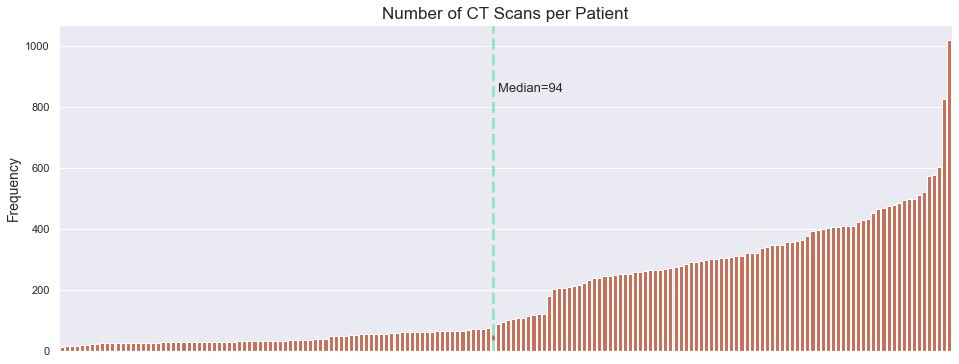

In [11]:
sns.set(color_codes=True)

custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']

train = pd.read_csv("D:\\Data\\OSIC\\osic-pulmonary-fibrosis-progression\\train.csv")


# Create base director for Train .dcm files
director = "D:\\Data\\OSIC\\osic-pulmonary-fibrosis-progression\\train"

# Create path column with the path to each patient's CT
train["Path"] = director + "/" + train["Patient"]

# Create variable that shows how many CT scans each patient has
train["CT_number"] = 0

for k, path in enumerate(train["Path"]):
    print("--------> ", path)
    train["CT_number"][k] = len(os.listdir(path))

print("Minimum number of CT scans: {}".format(train["CT_number"].min()), "[" , train[train["CT_number"]==12].Patient.unique()[0] , "]" , "\n" + "Maximum number of CT scans: {:,}".format(train["CT_number"].max()), train[train["CT_number"]==1018].Patient.unique()[0] , "]" )

# Scans per Patient
data = train.groupby(by="Patient")["CT_number"].first().reset_index(drop=False)
# Sort by Weeks
data = data.sort_values(['CT_number']).reset_index(drop=True)

# Plot
plt.figure(figsize = (16, 6))
p = sns.barplot(data["Patient"], data["CT_number"], color=custom_colors[5])
plt.axvline(x=85, color=custom_colors[2], linestyle='--', lw=3)

plt.title("Number of CT Scans per Patient", fontsize = 17)
plt.xlabel('Patient', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.text(86, 850, "Median=94", fontsize=13)

p.axes.get_xaxis().set_visible(False);

plt.show()


Many-to-Many Sequence Problems
Encoder-Decoder Model

In [12]:
X = list()
Y = list()
X = [x for x in range(5, 301, 5)]
Y = [y for y in range(20, 316, 5)]

X = np.array(X).reshape(20, 3, 1)
Y = np.array(Y).reshape(20, 3, 1)

In [30]:
DROPOUT = 0.3
INPUT_IMAGE_SIZE=512
H_UNIT = 1

In [31]:
def get_model(image_size):
    
    encoder_inputs = Input(shape=(1024,image_size,image_size,1))
    #512
    encoder_convL_1=TimeDistributed(Conv2D(H_UNIT, 3, activation = 'sigmoid', padding = 'same'))
    convL = encoder_convL_1(encoder_inputs)
    encoder_convL_2=TimeDistributed(Conv2D(H_UNIT, 3, activation = 'sigmoid', padding = 'same'))
    convL = encoder_convL_2(convL)
    convL = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(convL)
    
    #256
    encoder_convL_3=TimeDistributed(Conv2D(H_UNIT*2, 3, activation = 'sigmoid', padding = 'same'))
    convL = encoder_convL_3(convL)
    encoder_convL_4=TimeDistributed(Conv2D(H_UNIT*2, 3, activation = 'sigmoid', padding = 'same'))
    convL = encoder_convL_4(convL)
    convL = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(convL)
    
    #128
    encoder_convL_5=TimeDistributed(Conv2D(H_UNIT*4, 3, activation = 'sigmoid', padding = 'same'))
    convL = encoder_convL_5(convL)
    encoder_convL_6=TimeDistributed(Conv2D(H_UNIT*4, 3, activation = 'sigmoid', padding = 'same'))
    convL = encoder_convL_6(convL)
    convL = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(convL)
    
    #64
    #encoder_convL_7=TimeDistributed(Conv2D(H_UNIT*8, 3, activation = 'sigmoid', padding = 'same'))
    #convL = encoder_convL_7(convL)
    #encoder_convL_8=TimeDistributed(Conv2D(H_UNIT*8, 3, activation = 'sigmoid', padding = 'same'))
    #convL = encoder_convL_8(convL)
    #convL = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(convL)
    
    #32
    encoder_convL_9=ConvLSTM2D(H_UNIT*8, 3, activation = 'sigmoid', padding = 'same', return_sequences=True)
    convL = encoder_convL_9(convL)
    encoder_convL_10=ConvLSTM2D(H_UNIT*8, 3, activation = 'sigmoid', padding = 'same', return_sequences=True)
    convL = encoder_convL_10(convL)
    convL = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(convL)
    
    #16
    #encoder_convL_11=ConvLSTM2D(H_UNIT*8, 1, activation = 'sigmoid', padding = 'same', return_sequences=True)
    #convL = encoder_convL_11(convL)
    #encoder_convL_12=ConvLSTM2D(H_UNIT*4, 1, activation = 'sigmoid', padding = 'same', return_sequences=True)
    #convL = encoder_convL_12(convL)
    #encoder_convL_13=ConvLSTM2D(H_UNIT*2, 1, activation = 'sigmoid', padding = 'same', return_sequences=True)
    #convL = encoder_convL_13(convL)
    #encoder_convL_14=ConvLSTM2D(H_UNIT, 1, activation = 'sigmoid', padding = 'same', return_sequences=True)
    #convL = encoder_convL_14(convL)
    encoder_convL_15=ConvLSTM2D(1, 1, activation = 'sigmoid', padding = 'same', return_sequences=True)
    convL = encoder_convL_15(convL)
    
    denL = Flatten()(convL)
    outL = Dense(140, activation="relu")(denL)
    
    model = Model(inputs=encoder_inputs, outputs=outL)
    
    #model.compile(optimizer = Adam(lr = 1e-6, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    return model
    
    
m = get_model(512)  
    

ResourceExhaustedError: OOM when allocating tensor with shape[1048576,140] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [26]:
m.predict(np.ones((1,1024,512,512,1)))

InternalError:  Dst tensor is not initialized.
	 [[{{node IteratorGetNext/_2}}]] [Op:__inference_predict_function_9492]

Function call stack:
predict_function


In [ ]:
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

model = Sequential()

# encoder layer
model.add(LSTM(100, activation='relu', input_shape=(3, 1)))

# repeat vector
model.add(RepeatVector(3))

# decoder layer
model.add(LSTM(100, activation='relu', return_sequences=True))

model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

print(model.summary())

In [ ]:
history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1, batch_size=3)

In [ ]:
test_input = array([300.0, 305.0, 310.0])
test_input = test_input.reshape((1, 3, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output)

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(3, 1))))
model.add(RepeatVector(3))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1, batch_size=3)